In [13]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
from problem import Fokker_Planck_2d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [15]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]



In [16]:
my_prob = Fokker_Planck_2d()
sigma_SDE = my_prob.sigma_SDE


def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    t = x_pde[:,[0]]
    mu1, mu2 = my_prob.mu_SDE(t)
    D = sigma_SDE**2 / 2


    grad_u = grad(u_pde, x_pde)
    u_t = grad_u[:, [0]]
    u_x = grad_u[:, [1]]
    u_y = grad_u[:, [2]]

    u_xx = grad(u_x, x_pde)[:, [1]]
    u_yy = grad(u_y, x_pde)[:, [2]]

    pde_value = u_t + mu1*u_x + mu2*u_y - D*(u_xx+u_yy)
    return pde_value

In [17]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_test = data['target_test'].item()['u']

x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_test = torch.from_numpy(target_test).float()
print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_test.shape, target_test.shape)


torch.Size([10000, 3]) torch.Size([10000, 1])
torch.Size([6300, 3]) torch.Size([6300, 1])
torch.Size([2000, 3]) torch.Size([2000, 1])


In [18]:
# test loss function
def model_test(x_in):
    u = my_prob.u_exact(x_in)['u']
    return u
criterion = nn.MSELoss()

op_pde = pde(x_pde, model_test)
loss_pde = criterion(op_pde, target_pde)
u_bd = model_test(x_bd)
loss_bd = criterion(u_bd, target_bd)

loss = loss_pde + loss_bd
print(loss.item(), loss_pde.item(), loss_bd.item())

3.3228856351835907e-16 2.827746173118985e-16 4.9513939589015667e-17


In [19]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [20]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_test = target_test.cuda()


In [21]:

def train(width):
    model  = FCNet(input_dim=3, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [22]:
width_vec = [1000,2000,3000,4000,5000 ]
result_all = []
for width in width_vec:
    print(width,'.....................')
    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

1000 .....................
0 0.039048485457897186
100 0.009189842268824577
200 0.008899624459445477
300 0.008759881369769573
400 0.008677897974848747
500 0.008529813960194588
600 0.008430486544966698
700 0.008302479051053524
800 0.00815163180232048
900 0.007930885069072247
1000 0.0075886668637394905
1100 0.0072461459785699844
1200 0.006993674673140049
1300 0.006812415085732937
1400 0.00666114641353488
1500 0.0065172514878213406
1600 0.009285444393754005
1700 0.0062089296989142895
1800 0.007106039673089981
1900 0.005855930969119072
2000 0.005684758070856333
2100 0.005559139419347048
2200 0.00542770279571414
2300 0.005290333181619644
2400 0.005150618962943554
2500 0.005012601613998413
2600 0.004877207800745964
2700 0.004743122961372137
2800 0.004629326052963734
2900 0.0045317127369344234
3000 0.00448413984850049
3100 0.004357845522463322
3200 0.004285994917154312
3300 0.004206682089716196
3400 0.004143720958381891
3500 0.004086893051862717
3600 0.00403172429651022
3700 0.0039991918019950

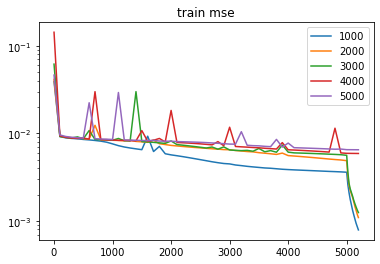

In [23]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

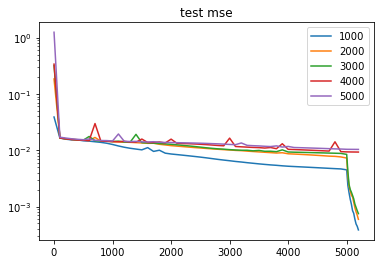

In [24]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [25]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [26]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')